<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import feature_importances, CVScores, RFECV
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix

# Loading Dataframe

In [3]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Prediction

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

In [4]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"]# + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [5]:
print(f"Columns being analysed: {len(TO_USE)}")
df[TO_USE].head()

Columns being analysed: 39


,koi_fpflag_nt,koi_kepmag,koi_steff_err2,koi_srad_err2,koi_depth,koi_model_snr,koi_prad,koi_fpflag_ec,koi_impact_err2,koi_period_err1,...,koi_fpflag_co,koi_slogg,koi_duration,koi_period,koi_srad_err1,koi_prad_err1,koi_prad_err2,ra,koi_steff,koi_insol_err2
0,0,15.347,-81.0,-0.061,615.8,35.8,2.26,0,-0.146,2.775000e-05,...,0,4.467,2.95750,9.488036,0.105,0.26,-0.15,291.93423,5455.0,-16.65
1,0,15.347,-81.0,-0.061,874.8,25.8,2.83,0,-0.443,2.479000e-04,...,0,4.467,4.50700,54.418383,0.105,0.32,-0.19,291.93423,5455.0,-1.62
2,0,15.436,-176.0,-0.078,10829.0,76.3,14.60,0,-0.077,1.494000e-05,...,0,4.544,1.78220,19.899140,0.233,3.92,-1.31,297.00482,5853.0,-10.49
3,0,15.597,-174.0,-0.067,8079.2,505.6,33.46,0,-0.092,2.630000e-07,...,0,4.564,2.40641,1.736952,0.201,8.50,-2.83,285.53461,5805.0,-230.35
4,0,15.509,-211.0,-0.133,603.3,40.9,2.75,0,-0.478,3.761000e-06,...,0,4.438,1.65450,2.525592,0.334,0.88,-0.35,288.75488,6031.0,-314.24


# Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the `disposition value` is *not* `CANDIDATE`. This is because `CANDIDATE` is the **default value** for all obects of interest picked up by Kepler. The labels `CONFIRMED` and `FALSE POSITIVE` serve as our positive and negative labels

#### Difference between disposition and pdisposition?

We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While `pdisposition` gives us the **most probable labels based on the physical explanation given by the readings**, `disposition` values are based on **the NASA Exoplanet Archive Data**.  

In [6]:
np.unique(df["koi_disposition"].values)

array(['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [7]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Obtaining X and y

We can encode the categorical labels to 1 and 0 for easier comparison
```
CONFIRMED - 1
FALSE POSITIVE - 0
```

In [8]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [9]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4647
CONFIRMED         2292
Name: koi_disposition, dtype: int64

# Data Visualisation

In [10]:
def getVisualisationPCA(X, y):
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()
    
    
def getVarianceContribution(X, y):
    cols = X.shape[1]
    x = StandardScaler().fit_transform(X)
    pca = PCA().fit(x)
    variance = pca.explained_variance_ratio_
    #print(variance)
    plt.bar(list(range(1, cols+1)), np.cumsum(variance)*100)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.grid()
    
    
def getFeatureCorrelation(X, y):
    visualizer = FeatureCorrelation(labels=TO_USE)
    visualizer.fit(X, y)
    visualizer.show()
    
    
def getPearsonRanking(X):
    visualizer = rank2d(X, features=TO_USE)
    visualizer.show()
    

def getRadialViz(X, y):
    visualizer = RadViz(classes=[0, 1], features = TO_USE)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show()              

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


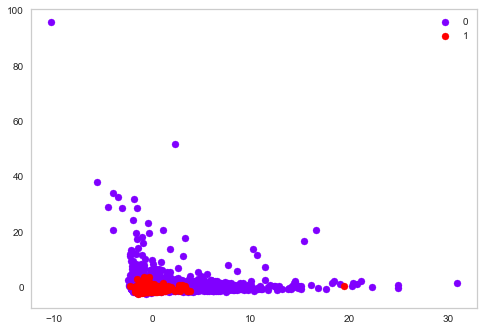

In [11]:
getVisualisationPCA(X, y)

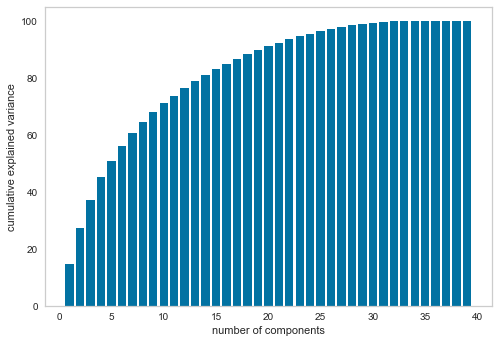

In [12]:
getVarianceContribution(X, y)

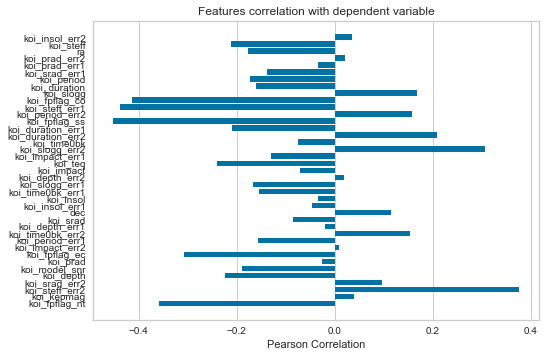

In [13]:
getFeatureCorrelation(X, y)

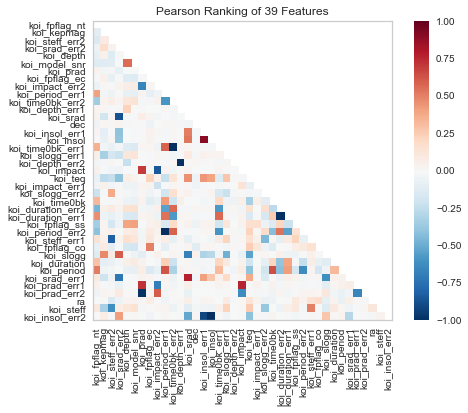

In [14]:
getPearsonRanking(X)

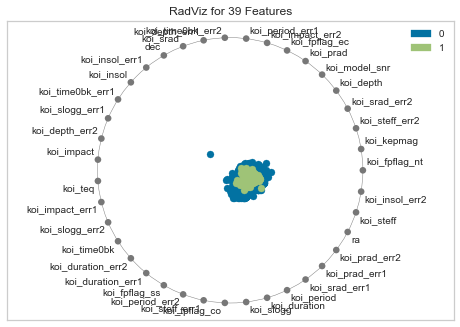

In [15]:
getRadialViz(X, y)

* We can see that our columns are not interdependent and we can use all our columns
* We observe that the two classes are **not** linearly separable, hence a simple Logistic Regression classifier will not do well.
* Most important, we see there is a **class imbalance** present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as 
* SVM
* Random Forests
* AdaBoost

# Splitting into Train and Test sets

* Scale the values to make the models less computationally expensive and convert all the values to the same range
* Split into train and test sets

In [16]:
X = StandardScaler().fit_transform(X)
X = PCA(n_components=30).fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 30), (2290, 30), (4649,), (2290,))

# Evaluation Metric 

Since the dataset is imbalanced, we cannot use accuracy, hence we opt for the following -
* Confusion Matrix
* F1 Score
* Cohen Kappa Score
* Balanced Accuracy Score

In [19]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

# Cross Validation Score

In [20]:
def crossValidationCheck(classifier, X, y, K=10):

    cv = KFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show()
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show()
    
    cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over Stratified {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show()
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show()

# Feature Importance

In [21]:
def getFeatureImportance(model, X, y):
    viz = feature_importances(model, X, y, labels=TO_USE)
    viz.fit(X, y)
    viz.show()

# Class Predictions

In [22]:
def getClassPredictionError(classifier):
    visualizer = ClassPredictionError(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
def getClassificationReport(classifier):
    visualizer = ClassificationReport(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
def getDiscriminationThreshold(classifier):
    visualizer = DiscriminationThreshold(classifier, exclude=["queue_rate"])
    visualizer.fit(X, y)        
    visualizer.show()
    
def getPrecisionRecall(classifier):
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
def rocCurve(classifier):
    visualizer = ROCAUC(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Recursive Feature Elimination

In [23]:
def getFeatureElimination(classifier, X, y):
    visualizer = RFECV(classifier)
    visualizer.fit(X, y)
    visualizer.show()           

# Saving and Loading Model

In [24]:
def saveModel(model, filename):
    joblib.dump(model, filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

# SVM

In [25]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [26]:
performance(y_test, pred)

F1 Score: 0.9846564376250834
Kappa Score: 0.977192163492392
Accuracy Score: 0.9864655118892407
Confusion Matrix:
[[1529    5]
 [  18  738]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1534
           1       0.99      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.99      0.99      2290
weighted avg       0.99      0.99      0.99      2290



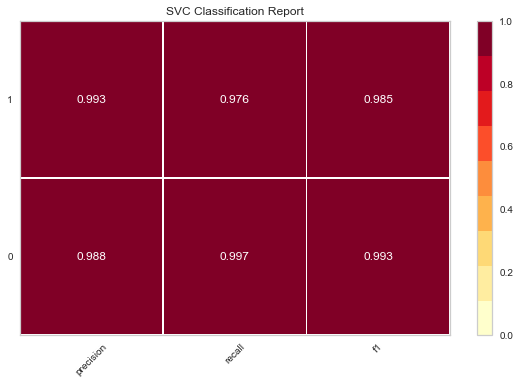

In [27]:
getClassificationReport(classifier)

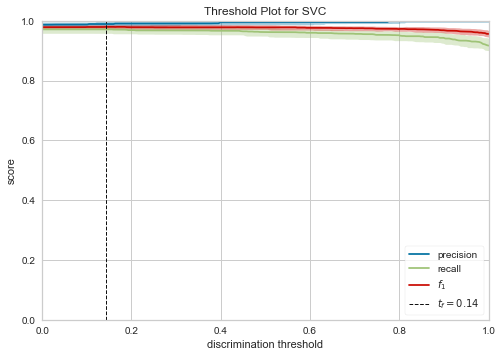

In [28]:
getDiscriminationThreshold(classifier)

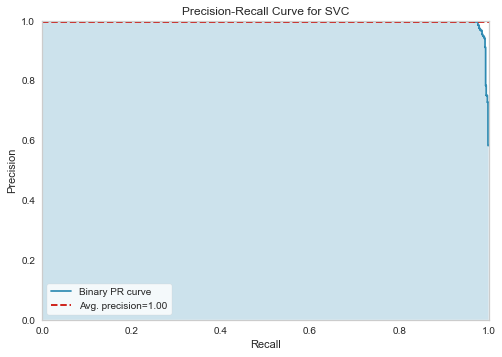

In [29]:
getPrecisionRecall(classifier)

## Checking Cross Validation Score

Average F1 score over 10-Folds: 0.9804332668598331


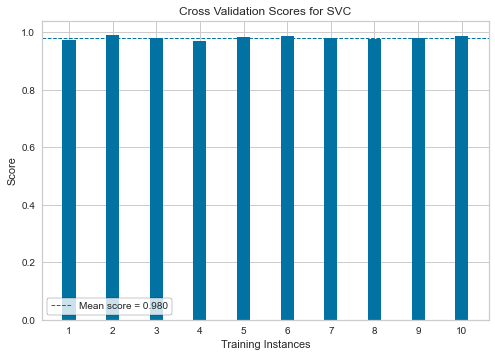

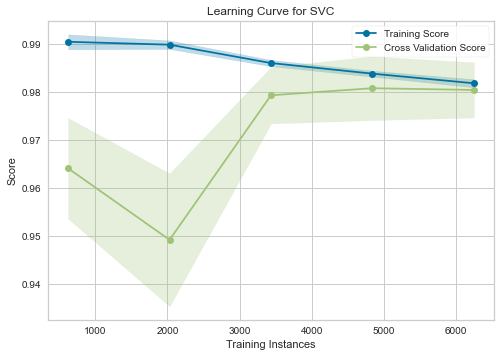

Average F1 score over Stratified 10-Folds: 0.9804111927737281


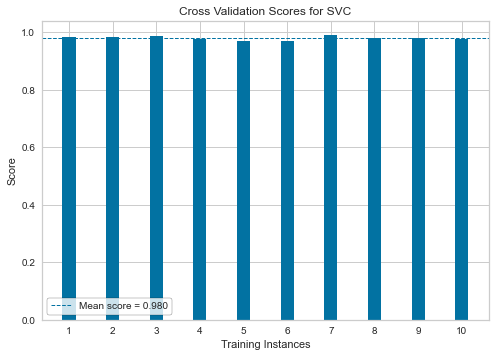

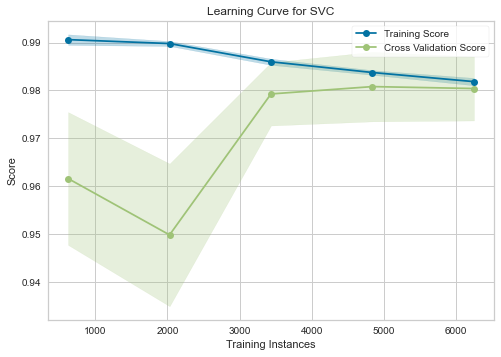

In [30]:
crossValidationCheck(classifier, X, y, K=10)

## Hyperparameter Tuning for SVM

In [31]:
parameters = {
    "C":np.arange(1, 5.05, 0.05),
    "gamma":["scale", "auto"],
    "shrinking":[True, False],
    "tol":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    "class_weight":[None, "balanced"]
}

scores = ["f1", "balanced_accuracy"]

In [32]:
classifier = GridSearchCV(
    SVC(kernel="rbf", random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 4536 candidates, totalling 22680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 3392 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4692 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7892 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11892 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 14192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 16692 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 19392 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 22292 tasks  

GridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15,
       3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ,
       3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
       4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
       4.85, 4.9 , 4.95, 5.  ]),
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'], 'shrinking': [True, False],
                         'tol': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]},
             refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [33]:
classifier.best_score_

0.9816109769125418

In [34]:
classifier.best_params_

{'C': 4.700000000000003,
 'class_weight': None,
 'gamma': 'auto',
 'shrinking': True,
 'tol': 1}

In [35]:
performance(y_test, classifier.best_estimator_.predict(X_test))

F1 Score: 0.9846768820786143
Kappa Score: 0.9772075210420408
Accuracy Score: 0.9868009423094168
Confusion Matrix:
[[1528    6]
 [  17  739]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1534
           1       0.99      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.99      0.99      2290
weighted avg       0.99      0.99      0.99      2290



Average F1 score over 10-Folds: 0.9830691985344264


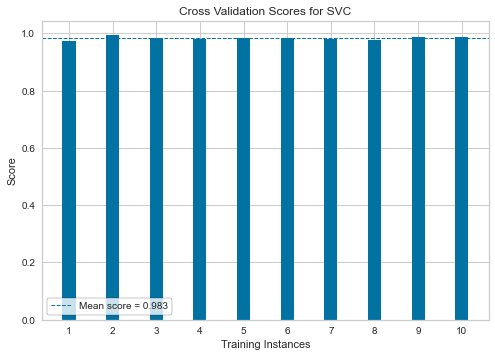

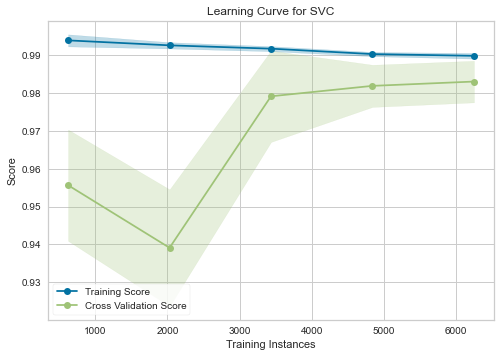

Average F1 score over Stratified 10-Folds: 0.9828041130852585


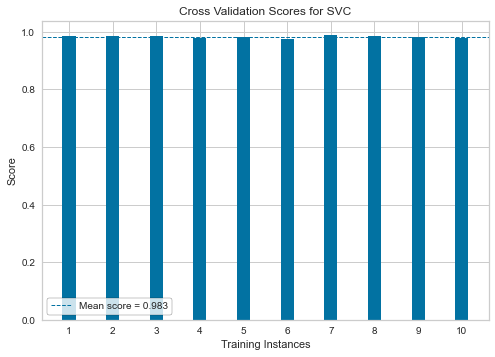

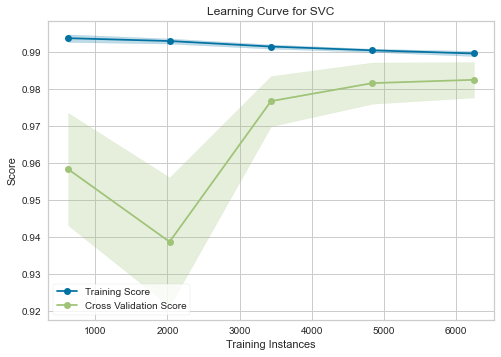

In [36]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

In [37]:
saveModel(classifier.best_estimator_, "../model/svm-error.model")

# Random Forest

In [38]:
classifier = RandomForestClassifier(random_state=0, n_jobs=-1)#, max_depth=8, n_estimators=400, min_samples_leaf=5)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [39]:
performance(y_test, pred)

F1 Score: 0.9757085020242915
Kappa Score: 0.9640951400394066
Accuracy Score: 0.9771967674510047
Confusion Matrix:
[[1531    3]
 [  33  723]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1534
           1       1.00      0.96      0.98       756

    accuracy                           0.98      2290
   macro avg       0.99      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



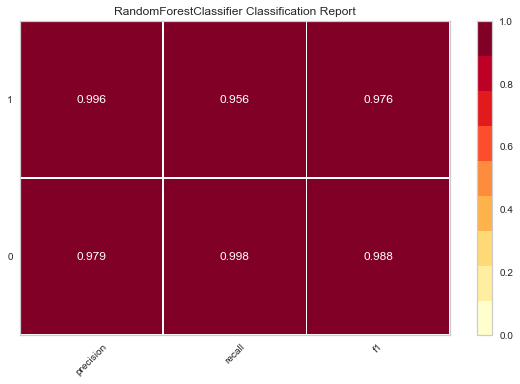

In [40]:
getClassificationReport(classifier)

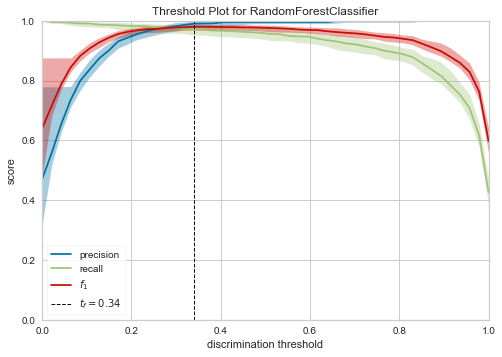

In [41]:
getDiscriminationThreshold(classifier)

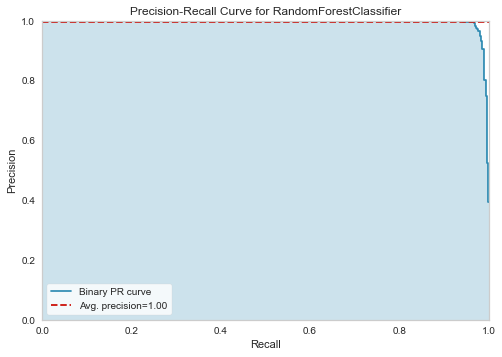

In [42]:
getPrecisionRecall(classifier)

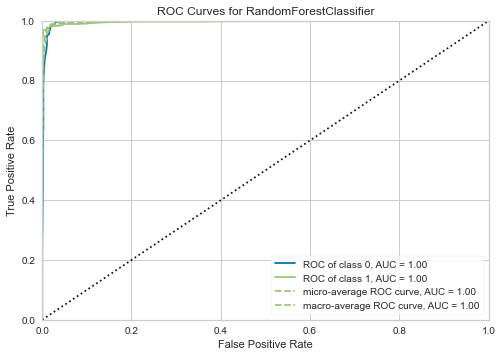

In [43]:
rocCurve(classifier)

## Checking Cross Validation Score

Average F1 score over 10-Folds: 0.9761823591272499


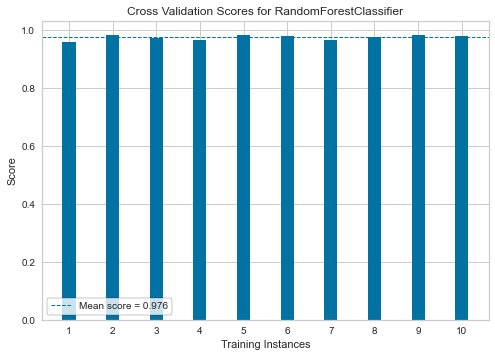

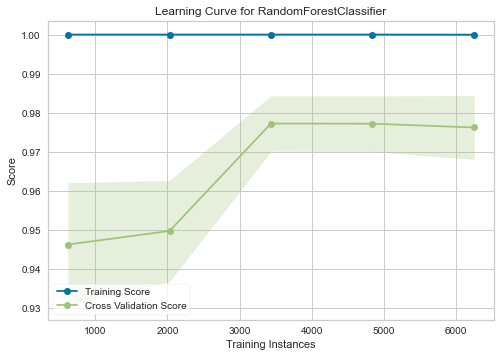

Average F1 score over Stratified 10-Folds: 0.9768412125719974


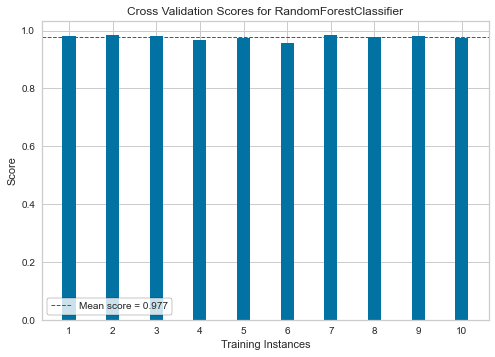

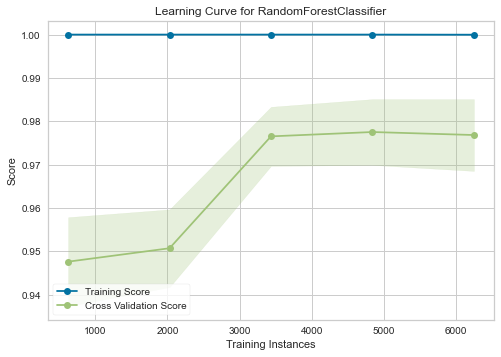

In [44]:
crossValidationCheck(classifier, X, y, K=10)

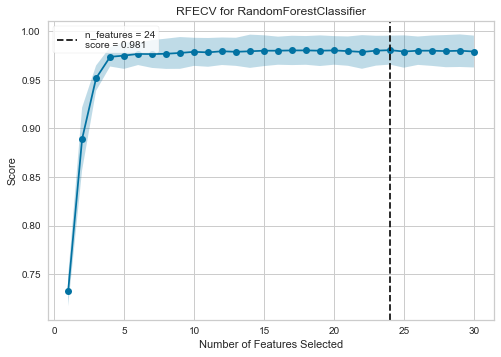

In [45]:
getFeatureElimination(classifier, X, y)

## Feature Importance

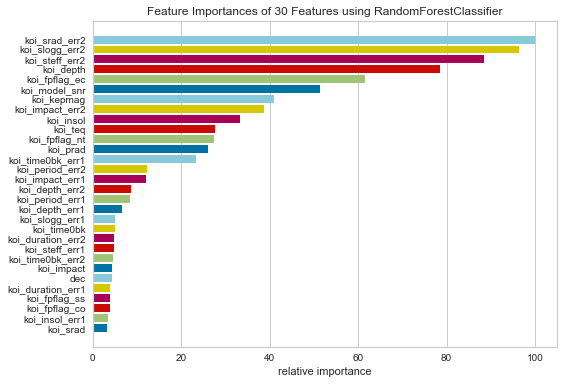

In [46]:
getFeatureImportance(classifier, X, y)

## Hyperparameter Tuning for Random Forest

In [47]:
"""parameters = {
    "n_estimators":np.arange(100,700,100),
    "max_depth":[None] + np.arange(1, 10, 1).tolist(),
    #"min_samples_split":np.arange(0, 1.1, 0.1),
    "min_samples_leaf":np.arange(0, 1.1, 0.2),
    "max_features":[None ,"sqrt", "log2"], #+ np.arange(1, 1.1, 0.1).tolist(),
    #"min_weight_fraction_leaf":np.arange(0, 11, 1),
    #"min_impurity_decrease":np.arange(1, 11, 1),
    "class_weight":[None, "balanced", "balanced_subsample"],
    #"max_leaf_nodes":[None] + np.arange(1, 11, 1).tolist(),
    #"ccp_alpha":np.arange(0, 1.1, 0.1)
}

scores = ["f1", "balanced_accuracy"]"""

'parameters = {\n    "n_estimators":np.arange(100,700,100),\n    "max_depth":[None] + np.arange(1, 10, 1).tolist(),\n    #"min_samples_split":np.arange(0, 1.1, 0.1),\n    "min_samples_leaf":np.arange(0, 1.1, 0.2),\n    "max_features":[None ,"sqrt", "log2"], #+ np.arange(1, 1.1, 0.1).tolist(),\n    #"min_weight_fraction_leaf":np.arange(0, 11, 1),\n    #"min_impurity_decrease":np.arange(1, 11, 1),\n    "class_weight":[None, "balanced", "balanced_subsample"],\n    #"max_leaf_nodes":[None] + np.arange(1, 11, 1).tolist(),\n    #"ccp_alpha":np.arange(0, 1.1, 0.1)\n}\n\nscores = ["f1", "balanced_accuracy"]'

In [48]:
saveModel(classifier, "../model/random-forest-error.model")

# Adaboost

In [49]:
classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [50]:
pred = classifier.predict(X_test)
performance(y_test, pred)

F1 Score: 0.9692101740294512
Kappa Score: 0.9543073578427035
Accuracy Score: 0.9742727454591862
Confusion Matrix:
[[1520   14]
 [  32  724]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1534
           1       0.98      0.96      0.97       756

    accuracy                           0.98      2290
   macro avg       0.98      0.97      0.98      2290
weighted avg       0.98      0.98      0.98      2290



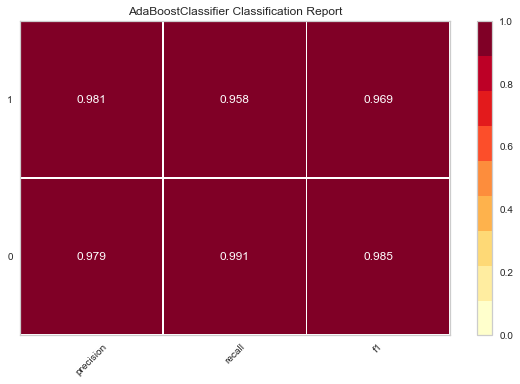

In [51]:
getClassificationReport(classifier)

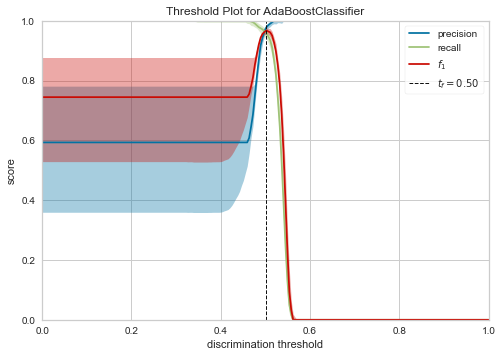

In [52]:
getDiscriminationThreshold(classifier)

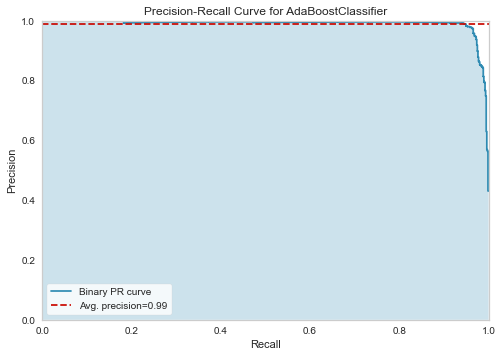

In [53]:
getPrecisionRecall(classifier)

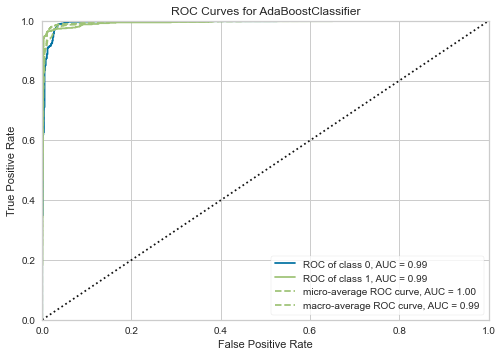

In [54]:
rocCurve(classifier)

## Checking Cross Validation Score

Average F1 score over 10-Folds: 0.962738683786076


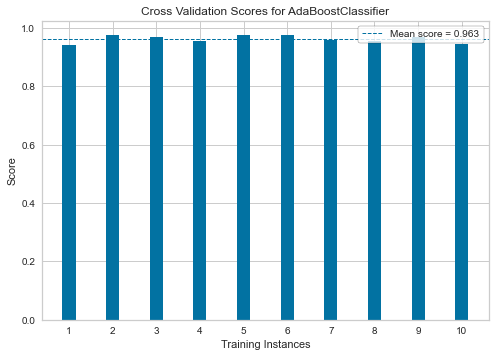

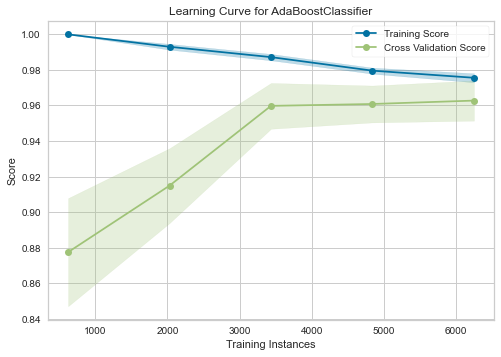

Average F1 score over Stratified 10-Folds: 0.966524885983963


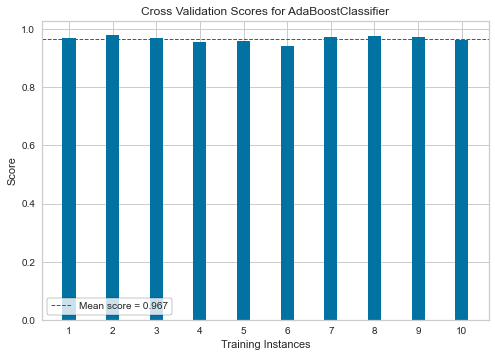

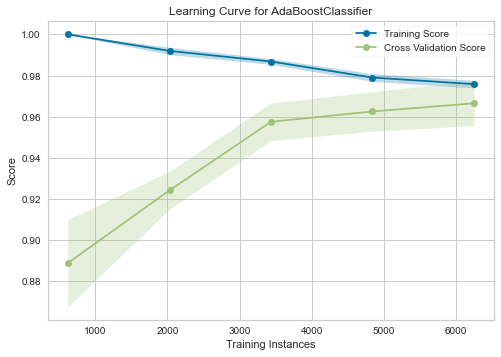

In [55]:
crossValidationCheck(classifier, X, y, K=10)

## Feature Elimination

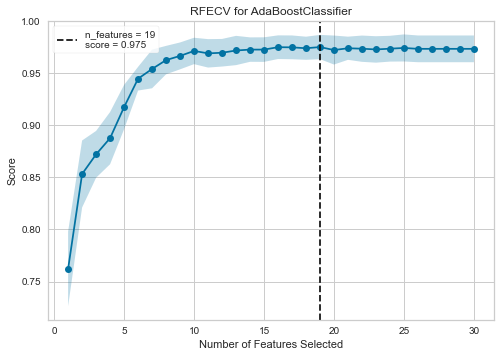

In [56]:
getFeatureElimination(classifier, X, y)

## Feature Importance

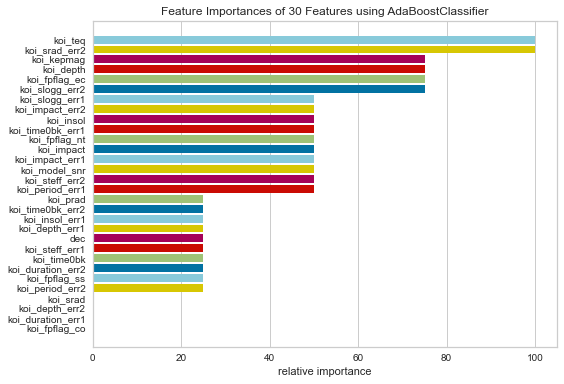

In [57]:
getFeatureImportance(classifier, X, y)

## Hyperparameter Tuning for AdaBoost

In [58]:
parameters = {
    "n_estimators":np.arange(50,150,10),
    "learning_rate":np.arange(0.5,1.5,0.05),
    "algorithm":["SAMME", "SAMME.R"],
    "base_estimator":[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=None)
    ]
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
classifier = GridSearchCV(
    AdaBoostClassifier(random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min


In [ ]:
classifier.best_score_

In [ ]:
classifier.best_params_

In [ ]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

In [ ]:
performance(y_test, classifier.best_estimator_.predict(X_test))

In [ ]:
saveModel(classifier.best_estimator_, "../model/adaboost-error.model")